In [1]:
import os
import math
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.interpolate as interpolate

tf.InteractiveSession()

model = "models/orig/karras2018iclr-lsun-tvmonitor-256x256.pkl"
model = "bbbgan-network-snapshot-011018.pkl"

print("open model %s" % model)
with open(model, 'rb') as file:
    G, D, Gs = pickle.load(file)

faves=[]

def bookmark(latents, new_faves):
    for f in new_faves:
        faves.append(latents[f])

def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], labels[6*r:min(n-1, 6*(r+1))])
        images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
        images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)
        
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, labels)
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

def get_latent_interpolation(endpoints, num_frames_per, mode, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    num_endpoints, dim = len(endpoints), len(endpoints[0])
    num_frames = num_frames_per * num_endpoints
    endpoints = np.array(endpoints)
    latents = np.zeros((num_frames, dim))
    for e in range(num_endpoints):
        e1, e2 = e, (e+1)%num_endpoints
        for t in range(num_frames_per):
            frame = e * num_frames_per + t
            r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
            latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
    return latents

def get_latent_interpolation_bspline(endpoints, nf, k, s, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    x = np.array(endpoints)
    x = np.append(x, x[0,:].reshape(1, x.shape[1]), axis=0)
    nd = x.shape[1]
    latents = np.zeros((nd, nf))
    nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))
    for i in tqdm(range(nd-9)):
        idx = list(range(i,i+10))
        tck, u = interpolate.splprep([x[:,j] for j in range(i,i+10)], k=k, s=s)
        out = interpolate.splev(np.linspace(0, 1, num=nf, endpoint=True), tck)
        latents[i:i+10,:] += np.array(out)
    latents = latents / np.array(nss).reshape((512,1))
    return latents.T


def generate_images(latents, labels):
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    images = []
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], labels[b*batch_size:min((b+1)*batch_size, num_frames-1),:])
        new_images = np.clip(np.rint((new_images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
        new_images = new_images.transpose(0, 2, 3, 1) # NCHW => NHWC
        for img in new_images:
            images.append(img)
    return images

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

open model bbbgan-network-snapshot-011018.pkl


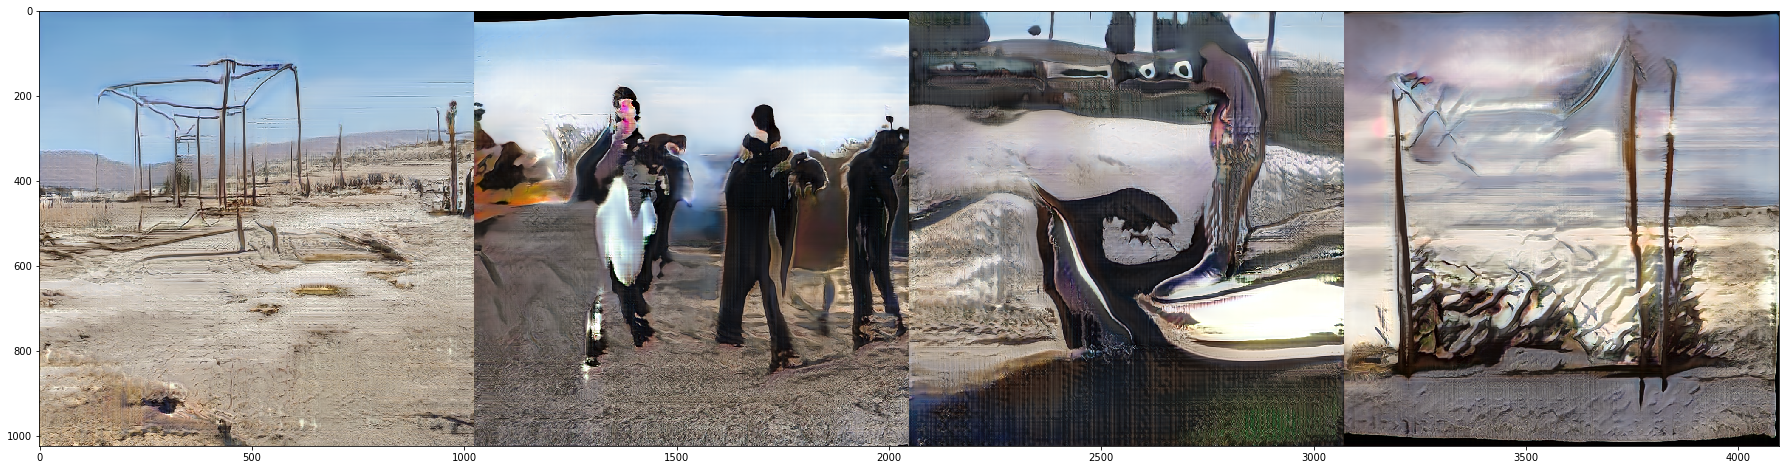

In [2]:
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, labels)
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

images, latents = random_sample(4, scale=8)

In [242]:
#faves=[]
bookmark(latents, [0])
#len(faves+faves[0])
#f2 =faves
#f2.append(f2[0])


In [3]:
import pickle
#pickle.dump(faves, open('bbbfaves.p','wb'))
faves = pickle.load(open('bbbfaves.p','rb'))

In [4]:
def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], labels[6*r:min(n-1, 6*(r+1))])
        images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
        images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)


zzz = [4, 15, 18, 20, 21, 22, 23, 30, 36, 40, 43, 44, 48, 54, 62, 64, 65, 73, 75, 78, 80, 85, 87, 89, 90, 101, 103, 105, 114, 127, 10, 2, 3, 11, 14, 27, 33, 38, 47, 50, 58, 60, 67, 77, 79, 97, 98, 106, 111, 118, 119, 125, 28, 1, 9, 42, 45, 49, 52, 56, 61, 63, 69, 71, 82, 83, 84, 86, 94, 102, 104, 112, 113, 120, 121, 123, 126, 24, 26, 35, 37, 39, 46, 53, 51, 81, 107, 109, 115, 116, 117, 129, 130, 132, 5, 41, 108, 110, 34, 72, 76, 92, 96, 7, 0, 8, 6, 12, 13, 16, 17, 19, 25, 29, 31, 32, 59, 66, 68, 70, 74, 91, 93, 99, 100, 122, 124, 128, 131]

#show_faves([faves[z_] for z_ in zzz])
#len(faves)
#show_faves(faves[42, 7, 30, 36, 38, 0, 2, 10, 12, 14, 15, 16, 17, 33, 1, 7, 6, 9, 21, 24, 35, 43, 44, 3, 37, 4, 13, 18, 19, 22, 23, 25, 26, 27, 29, 31, 5, 11, 20, 28, 39, 40, 41, 38, 34, 8, 32])

In [ ]:



def generate_movie(latents, labels, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    frame = 1
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], labels[b*batch_size:min((b+1)*batch_size, num_frames-1),:])
        new_images = np.clip(np.rint((new_images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
        new_images = new_images.transpose(0, 2, 3, 1) # NCHW => NHWC
        for img in new_images:
            PIL.Image.fromarray(img, 'RGB').save('%s/frame%05d.png' % (temp_dir, frame))
            frame += 1
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

    
    

faves2 = [faves[z_] for z_ in zzz]

#latents = get_latent_interpolation(faves2, 59, 'linear', shuffle=False)
#latents2 = get_latent_interpolation_bspline(faves, 25*len(faves), 5, 500, False)
#labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

#generate_movie(latents, labels, '.', 'BBBgan3_longer')

#images = generate_images(latents, labels)    
# #make_movie(images, '.', 'screens3')

#images2 = generate_images(latents2, labels)    
# #make_movie(images2, '.', 'screens3_spline')

#images3 = [ np.concatenate([img1, img2], axis=1) for img1, img2 in zip(images, images2)]
#make_movie(images, '.', 'BBBgan3_longer')



latents = get_latent_interpolation_bspline(faves2, 30*len(faves2), 3, 40, shuffle=False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
generate_movie(latents, labels, '.', 'BBGAN_30_spline_5_300')


latents = get_latent_interpolation(faves2, 60, 'ease', shuffle=False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
generate_movie(latents, labels, '.', 'BBGAN_60_ease')


latents = get_latent_interpolation(faves2, 200, 'linear', shuffle=False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
generate_movie(latents, labels, '.', 'BBGAN_200_linear')


latents = get_latent_interpolation(faves2, 200, 'ease', shuffle=False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
generate_movie(latents, labels, '.', 'BBGAN_200_ease')


#####

latents = get_latent_interpolation_bspline(faves2, 60*len(faves2), 3, 40, shuffle=False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
generate_movie(latents, labels, '.', 'BBGAN_60_spline_3_40')

latents = get_latent_interpolation_bspline(faves2, 200*len(faves2), 3, 40, shuffle=False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
generate_movie(latents, labels, '.', 'BBGAN_200_spline_3_40')







 22%|██▏       | 110/503 [00:00<00:01, 213.21it/s]/home/bzion/.local/share/virtualenvs/progressive_growing_of_gans-g0_yKZIh/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
  8%|▊         | 38/484 [02:21<27:24,  3.69s/it]

In [7]:
latents = get_latent_interpolation_bspline(faves2, 30*len(faves2), 5, 500, False)
latents.shape

100%|██████████| 503/503 [00:00<00:00, 836.21it/s]


(129, 512)

In [38]:
pickle.dump(faves, open('myfavess.p','wb'))

In [3]:
faves = pickle.load(open('myfavess.p', 'rb'))

In [243]:
from scipy.interpolate import interp1d
#x = np.linspace(0, 10, num=11, endpoint=True)
y = np.random.random([1,11])
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

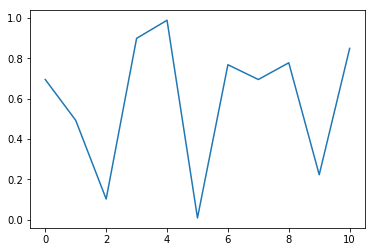

In [244]:
import matplotlib.pyplot as plt
plt.plot(x,y[0])

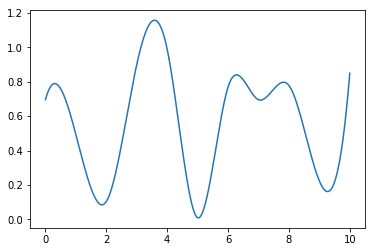

In [246]:
import matplotlib.pyplot as plt
x2 = np.linspace(0, 10, num=1000, endpoint=True)
plt.plot(x2,f2(x2)[0])
#plt.plot(x2,f(x2)[0])


In [207]:
import matplotlib.pyplot as plt
x2 = np.linspace(0, 10, num=1000, endpoint=True)
plt.plot(x2,f2(x2)[0])
#plt.plot(x2,f(x2)[0])


array([], shape=(0, 10), dtype=float64)

In [252]:
from scipy.spatial.distance import euclidean
x = np.array(faves)

d = [euclidean(x[i,:], x[i+1,:]) for i in range(x.shape[0]-1)]
d/np.min(d)

array([1.04268927, 1.        , 1.06147455, 1.11839148, 1.09377618,
       1.1041123 , 1.12329761, 1.14136686, 1.10121221, 1.06292774,
       1.03548222, 1.0338692 , 1.06025134, 1.10137738])

In [221]:
x.shape

(15, 512)

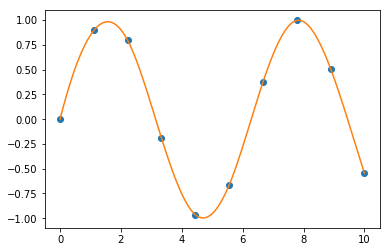

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

x = np.linspace(0, 10, 10) # x-coordinates
y = np.sin(x) # y-coordinates
tck = splrep(x, y) # get bspline representation given (x,y) values
x2 = np.linspace(0, 10, 200) # new set of values, just to check
y2 = splev(x2, tck) # evaluate the y values of new coordinates on NURBS curve
plt.plot(x, y, 'o', x2, y2) 
plt.show()

In [225]:
tck

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  2.22222222,
         3.33333333,  4.44444444,  5.55555556,  6.66666667,  7.77777778,
        10.        , 10.        , 10.        , 10.        ]),
 array([-4.94881722e-18,  8.96543619e-01,  1.39407154e+00, -2.36640266e-01,
        -1.18324030e+00, -8.16301228e-01,  4.57836125e-01,  1.48720677e+00,
         1.64338775e-01, -5.44021111e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 3)

In [233]:
import os
from geomdl import BSpline
from geomdl import utilities
from geomdl import exchange

from geomdl.visualization import VisMPL


# Fix file path
os.chdir(os.path.dirname(os.path.realpath("hello.txt")))

# Create a B-Spline curve instance
curve = BSpline.Curve()

# Set up curve
curve.ctrlpts = exchange.import_txt("ex_curve3d01.cpt")
curve.degree = 4

# Auto-generate knot vector
curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))

# Set evaluation delta
curve.delta = 0.001

# Evaluate curve
curve.evaluate()

# Plot the control point polygon and the evaluated curve
vis_comp = VisMPL.VisCurve3D()
curve.vis = vis_comp
curve.render()

# Insert a knot
u = 0.2
curve.insert_knot(u)

# Draw the control point polygon and the evaluated curve after knot insertion
curve.render()

# Good to have something here to put a breakpoint
pass

AttributeError: module 'geomdl.exchange' has no attribute 'import_txt'

In [231]:
!pip3 install bpy --user

  Using cached https://files.pythonhosted.org/packages/5d/03/9896a05aac246d3a46b1a49c1eb796a51ecc4e0ae30e9e7c5d52cbc52662/bpy-1.2.1.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-build-_pw3f6z3/bpy/setup.py", line 88
        self.announce(f"Cloning Blender source from {BLENDER_GIT_REPO_URL}...",
                                                                             ^
    SyntaxError: invalid syntax
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-_pw3f6z3/bpy/
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [320]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt

#x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
#y = np.sin(x)

#ctr =np.array( [(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
#                (-3, 0), (-2.5, -4), (0, -1), (2.5, -4), (3, -1)])

#ctr = np.array(  [ (-3+6*np.random.random(), -3+6*np.random.random()) for i in range(6) ] )

x=ctr[:,0]
y=ctr[:,1]

#x=np.append(x,x[0])
#y=np.append(y,y[0])

tck,u = interpolate.splprep([x,y,y,y,x,y,x,y],k=5,s=5)
u=np.linspace(0,1,num=50,endpoint=True)
out = interpolate.splev(u,tck)
print(np.array(out).shape)
# plt.figure()
# plt.plot(x, y, 'ro', out[0], out[1], 'b')
# plt.legend(['Points', 'Interpolated B-spline', 'True'],loc='best')
# plt.axis([min(x)-1, max(x)+1, min(y)-1, max(y)+1])
# plt.title('B-Spline interpolation')
# plt.show()

(8, 50)


In [464]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt


def getbs(faves, nf, k, s):
    x = np.array(faves)
    nd = x.shape[1]
    z = np.zeros((nd, nf))
    nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))
    for i in tqdm(range(nd-9)):
        idx = list(range(i,i+10))
        tck, u = interpolate.splprep([x[:,j] for j in range(i,i+10)], k=k, s=s)
        out = interpolate.splev(np.linspace(0, 1, num=nf, endpoint=True), tck)
        latents[i:i+10,:] += np.array(out)
    latents = latents / np.array(nss).reshape((512,1))
    return latents.T



# plt.figure()
# plt.plot(x, y, 'ro', out[0], out[1], 'b')
# plt.legend(['Points', 'Interpolated B-spline', 'True'],loc='best')
# plt.axis([min(x)-1, max(x)+1, min(y)-1, max(y)+1])
# plt.title('B-Spline interpolation')
# plt.show()

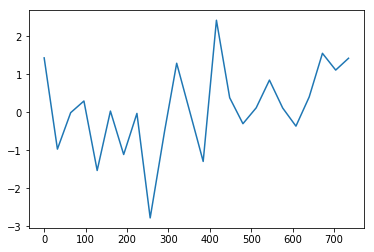

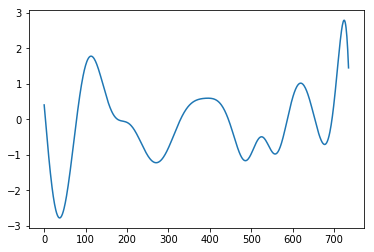

In [538]:


for z in range(1):
    plt.figure()
    plt.plot(range(736), latents[:,z])
    plt.figure()
    plt.plot(range(736), latents2[:,z])


100%|██████████| 503/503 [00:00<00:00, 3415.25it/s]


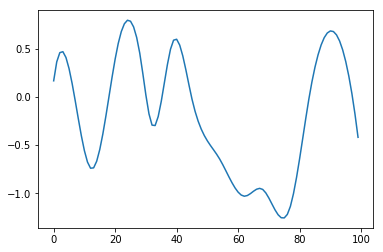

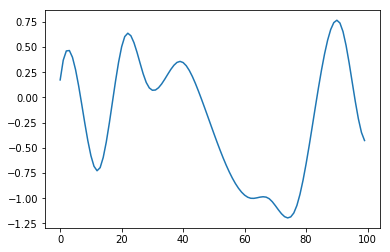

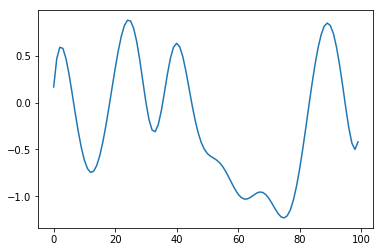

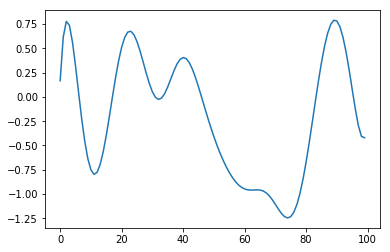

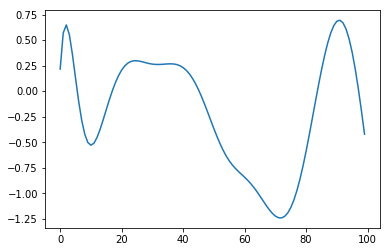

In [466]:

latents30 = getbs(faves, 100, 3, 0)
latents35 = getbs(faves, 100, 3, 5)
latents50 = getbs(faves, 100, 5, 0)
latents55 = getbs(faves, 100, 5, 5)
latents530 = getbs(faves, 100, 5, 30)

for z in range(1):
    plt.figure()
    plt.plot(range(100), latents30[:,z])
    plt.figure()
    plt.plot(range(100), latents35[:,z])
    plt.figure()
    plt.plot(range(100), latents50[:,z])
    plt.figure()
    plt.plot(range(100), latents55[:,z])
    plt.figure()
    plt.plot(range(100), latents530[:,z])

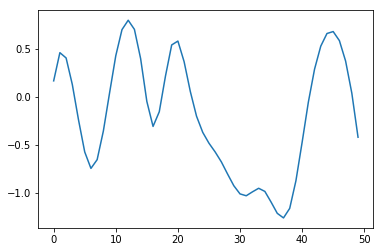

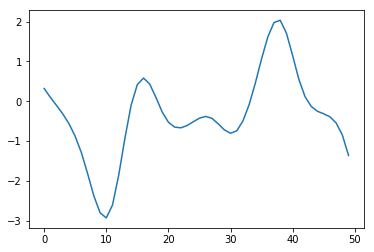

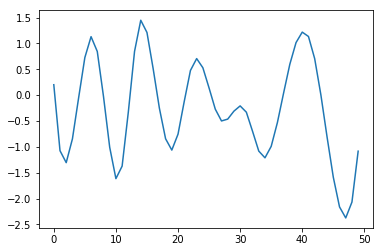

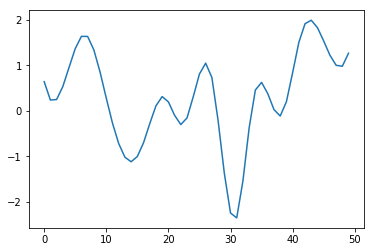

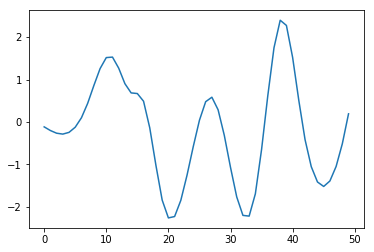

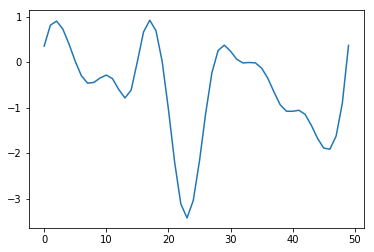

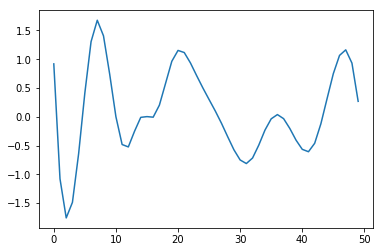

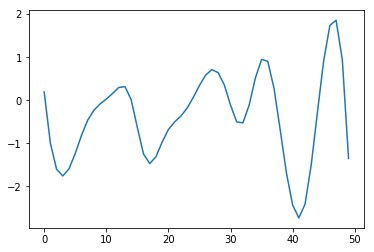

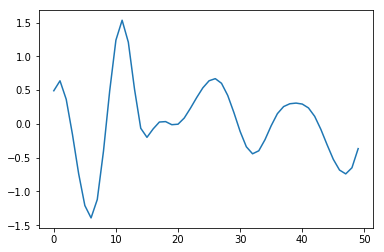

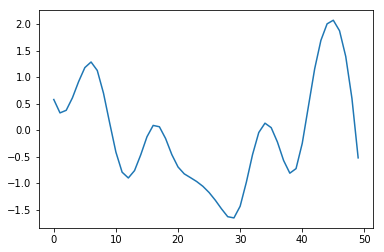

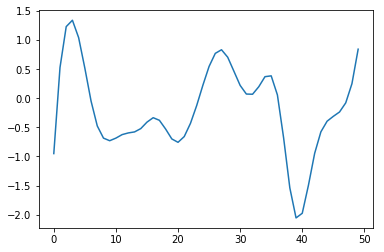

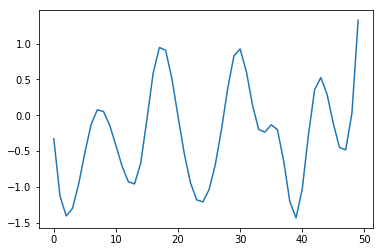

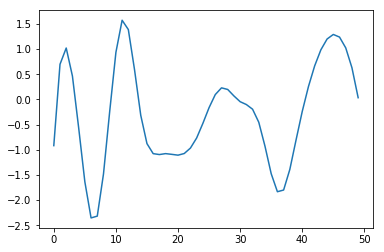

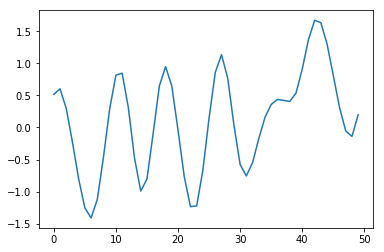

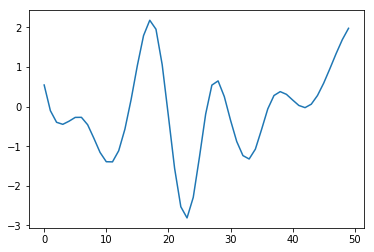

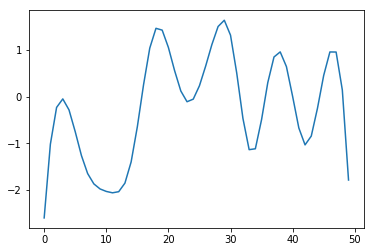

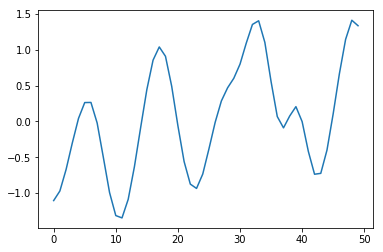

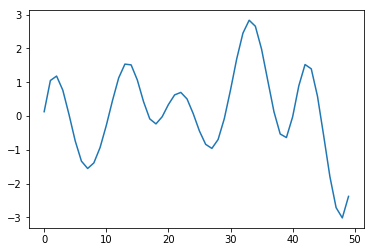

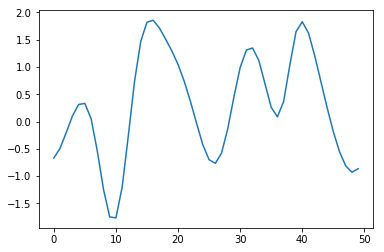

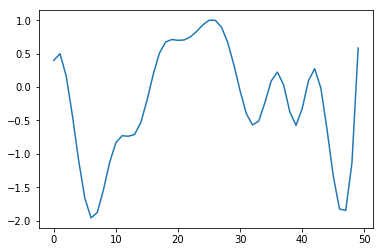

In [461]:
for z in range(20):
    plt.figure()
    plt.plot(range(50), latents[:,z])

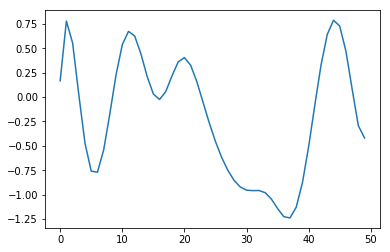

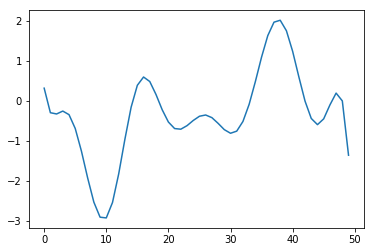

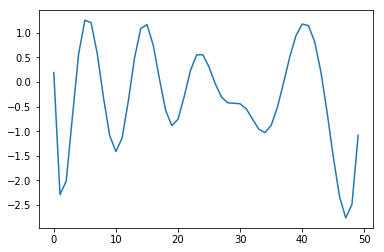

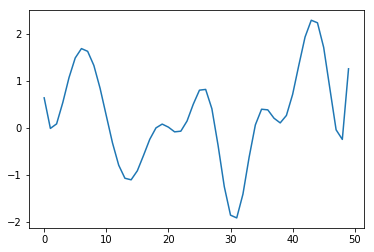

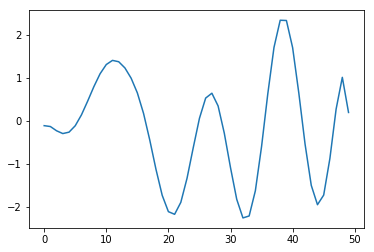

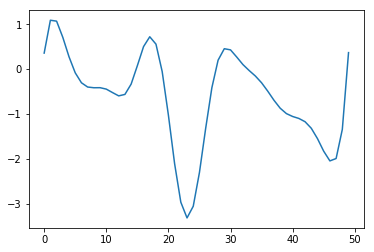

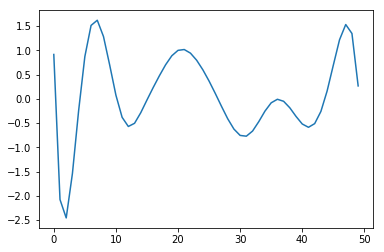

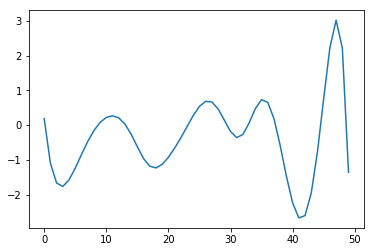

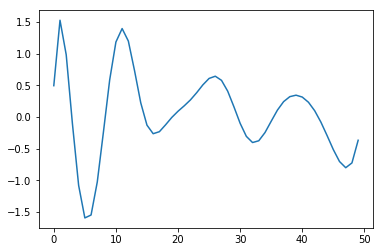

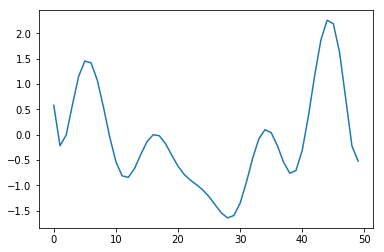

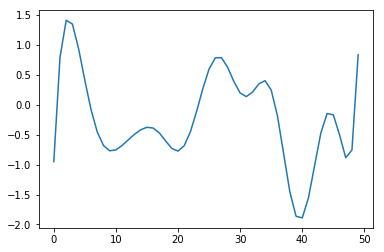

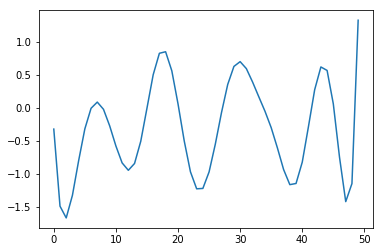

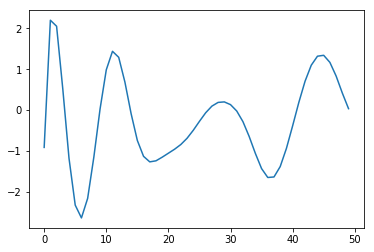

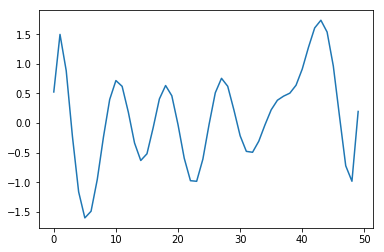

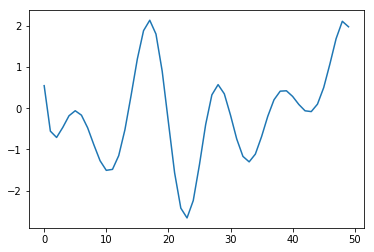

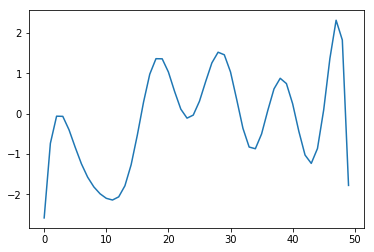

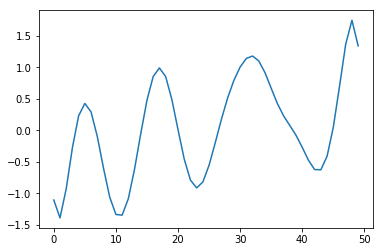

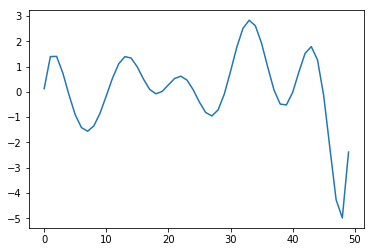

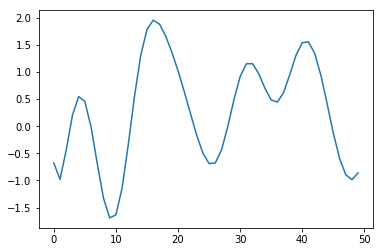

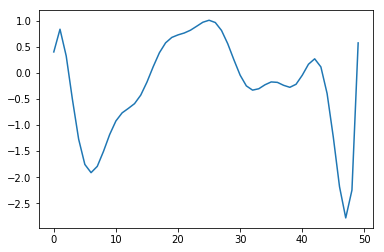

In [463]:
for z in range(20):
    plt.figure()
    plt.plot(range(50), latents[:,z])

In [405]:
#ns
nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))

In [406]:
ns==nss

True

In [411]:
z[0]

array([ 0.16735266,  0.77876082,  0.55548266,  0.02499251, -0.47379302,
       -0.75830926, -0.77013793, -0.54280137, -0.16955696,  0.22880859,
        0.5361849 ,  0.67331752,  0.62555274,  0.44250332,  0.21215583,
        0.03162868, -0.02493653,  0.05678471,  0.21727893,  0.36003563,
        0.40434411,  0.32702756,  0.15798062, -0.05249885, -0.26399194,
       -0.45516983, -0.61814801, -0.75150458, -0.85373769, -0.92141366,
       -0.95376133, -0.95858769, -0.95725993, -0.97958288, -1.04479835,
       -1.14162313, -1.2256485 , -1.23816156, -1.12883972, -0.87801466,
       -0.50931141, -0.08111567,  0.32917234,  0.64110235,  0.7871386 ,
        0.72862435,  0.47174635,  0.08349942, -0.29234906, -0.41929466])

In [381]:
ns[0:20]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.21323771, 0.28378301, 0.32425591, 0.39251072,
        0.45529956, 0.54435151, 0.62598005, 0.68599292, 0.77398043,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]),
 [array([ 0.16735266,  2.79655971, -5.05060247,  2.07461003,  0.73841446,
         -0.4950645 ,  0.9880417 , -0.18227632, -0.75239161, -1.15748205,
         -0.46495408, -3.21660023,  4.01048306, -0.6468138 , -0.41929466]),
  array([ 0.31741513, -1.68929061,  3.66719097, -8.07555008, -0.58721455,
          1.39339355, -0.98742073, -0.88331551,  0.35497418, -1.7072963 ,
          0.76559015,  6.55652552, -7.33857837,  3.70837595, -1.35868845]),
  array([  0.18972182,  -7.96318488,  14.06729601, -10.62523385,
           3.03798661,   1.09699965,  -2.97060575,   3.10831942,
          -1.79570026,   0.78882481,  -3.72173284,   4.36266973,
           1.26512503,  -5.67092377,  -1.08336398]),
  array([ 

In [424]:
out[j]

IndexError: list index out of range

In [358]:
ns

[0,
 0,
 0,
 0]

In [329]:
x[:,0:2].T.shape

(2, 15)

In [335]:
x.shape

(15, 512)